## CIFAR10 Image Classification Production Deployment

![cifar10](demo.png)

We show an image classifier (CIFAR10) with associated outlier and drift detectors using a Pipeline.

 * The model is a tensorflow [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) image classfier 
 * The outlier detector is created from the [CIFAR10 VAE Outlier example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_cifar10.html).
 * The drift detector is created from the [CIFAR10 KS Drift example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_ks_cifar10.html)
 
### Model Training (optional for notebook)

Here we describe how we created the artifacts. This is not needed to run this notebook but will help you to apply these techniques to your own models.

#### Outlier Detection Model

Follow the Alibi-Detect outlier detector example [CIFAR10 VAE Outlier example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_cifar10.html).

Use the `save_detector` command to save the trained outlier detector as shown in the notebook.

Create a MLServer model settings file: `model-settings.json`:

```json
{
  "name": "cifar10-outlier-detect",
  "implementation": "mlserver_alibi_detect.AlibiDetectRuntime",
  "parameters": {
    "uri": "./",
    "version": "v0.1.0"
  }
}

```

Save to local or remote storage the directory. Here we saved to Google Storage:

```bash
gsutil ls -R gs://seldon-models/mlserver/alibi-detect/cifar10-outlier 

gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/:
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/OutlierVAE.dill
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/meta.dill
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model-settings.json
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model/:
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model/checkpoint
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model/decoder_net.h5
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model/encoder_net.h5
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model/vae.ckpt.data-00000-of-00001
gs://seldon-models/mlserver/alibi-detect/cifar10-outlier/model/vae.ckpt.index

```
 
 ### Drift Detector
 
Follow the Alibi-Detect drift detection example [CIFAR10 KS Drift example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_ks_cifar10.html).

Use the `save_detector` command to save the trained outlier detector as shown in the notebook.

Create a MLServer model settings file: `model-settings.json`:

```json
{
  "name": "cifar10-drift",
  "implementation": "mlserver_alibi_detect.AlibiDetectRuntime",
  "parameters": {
    "uri": "./",
    "version": "v0.1.0"
  }
}
```

Save to local or remote storage the directory. Here we saved to Google Storage:

```bash
gsutil ls -R gs://seldon-models/mlserver/alibi-detect/cifar10-drift 

gs://seldon-models/mlserver/alibi-detect/cifar10-drift/:
gs://seldon-models/mlserver/alibi-detect/cifar10-drift/
gs://seldon-models/mlserver/alibi-detect/cifar10-drift/KSDrift.dill
gs://seldon-models/mlserver/alibi-detect/cifar10-drift/meta.dill
gs://seldon-models/mlserver/alibi-detect/cifar10-drift/model-settings.json
gs://seldon-models/mlserver/alibi-detect/cifar10-drift/model/:
gs://seldon-models/mlserver/alibi-detect/cifar10-drift/model/encoder.h5

```
 
 

In [1]:
import requests
import json
from typing import Dict, List
import numpy as np
import os
import tensorflow as tf
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.datasets import fetch_cifar10c
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

2022-06-24 09:13:02.143420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 09:13:02.143442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
outliers = []
for idx in range(0,X_train.shape[0]):
    X_mask, mask = apply_mask(X_train[idx].reshape(1, 32, 32, 3),
                                  mask_size=(12,12),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
    outliers.append(X_mask)
X_outliers = np.vstack(outliers)
X_outliers.shape

(50000, 32, 32, 3)

In [4]:
corruption = ['gaussian_noise']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [5]:
reqJson = json.loads('{"inputs":[{"name":"input_1","data":[],"datatype":"FP32","shape":[]}]}')
url = "http://0.0.0.0:9000/v2/models/model/infer"

In [6]:
def infer(resourceName: str, batchSz: int, requestType: str):
    if requestType == "outlier":
        rows = X_outliers[0:0+batchSz]
    elif requestType == "drift":
        rows = X_corr[0:0+batchSz]
    else:
        rows = X_train[0:0+batchSz]
    for i in range(batchSz):
        show(rows[i])
    reqJson["inputs"][0]["data"] = rows.flatten().tolist()
    reqJson["inputs"][0]["shape"] = [batchSz, 32, 32, 3]
    headers = {"Content-Type": "application/json", "seldon-model":resourceName}
    response_raw = requests.post(url, json=reqJson, headers=headers)
    print(response_raw)
    print(response_raw.json())
    

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


### Pipeline

In [33]:
!cat ../../models/cifar10.yaml
!echo "---"
!cat ../../models/cifar10-outlier-detect.yaml
!echo "---"
!cat ../../models/cifar10-drift-detect.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10
  namespace: seldon-mesh
spec:
  storageUri: "gs://seldon-models/triton/tf_cifar10"
  requirements:
  - tensorflow
---
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10-outlier
  namespace: seldon-mesh
spec:
  storageUri: "gs://seldon-models/mlserver/alibi-detect/cifar10-outlier"
  requirements:
    - mlserver
    - alibi-detect
---
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10-drift
  namespace: seldon-mesh
spec:
  storageUri: "gs://seldon-models/mlserver/alibi-detect/cifar10-drift"
  requirements:
    - mlserver
    - alibi-detect


In [34]:
!seldon model load -f ../../models/cifar10.yaml
!seldon model load -f ../../models/cifar10-outlier-detect.yaml
!seldon model load -f ../../models/cifar10-drift-detect.yaml

{}
{}
{}


In [35]:
!seldon model status cifar10 -w ModelAvailable | jq .
!seldon model status cifar10-outlier -w ModelAvailable | jq .
!seldon model status cifar10-drift -w ModelAvailable | jq .

{}
{}
{}


In [36]:
!cat ../../pipelines/cifar10.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Pipeline
metadata:
  name: cifar10-production
  namespace: seldon-mesh
spec:
  steps:
    - name: cifar10
    - name: cifar10-outlier
    - name: cifar10-drift
      batch:
        size: 20
  output:
    steps:
    - cifar10
    - cifar10-outlier.outputs.is_outlier


In [37]:
!seldon pipeline load -f ../../pipelines/cifar10.yaml

{}


In [38]:
!seldon pipeline status cifar10-production -w PipelineReady| jq -M .

{
  "pipelineName": "cifar10-production",
  "versions": [
    {
      "pipeline": {
        "name": "cifar10-production",
        "uid": "caqonpp64e2ahltbcce0",
        "version": 1,
        "steps": [
          {
            "name": "cifar10"
          },
          {
            "name": "cifar10-drift",
            "batch": {
              "size": 20
            }
          },
          {
            "name": "cifar10-outlier"
          }
        ],
        "output": {
          "steps": [
            "cifar10.outputs",
            "cifar10-outlier.outputs.is_outlier"
          ]
        },
        "kubernetesMeta": {
          "namespace": "seldon-mesh"
        }
      },
      "state": {
        "pipelineVersion": 1,
        "status": "PipelineReady",
        "reason": "Created pipeline",
        "lastChangeTimestamp": "2022-06-24T10:03:19.836347885Z"
      }
    }
  ]
}


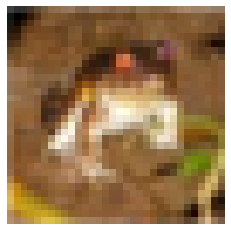

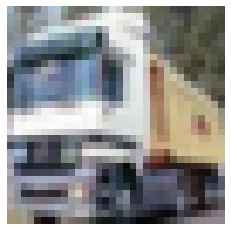

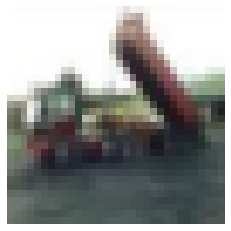

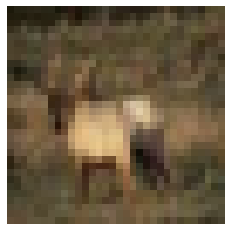

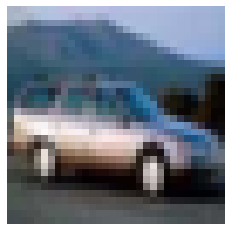

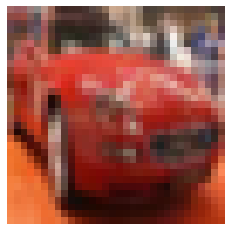

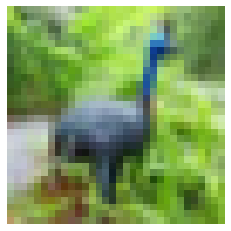

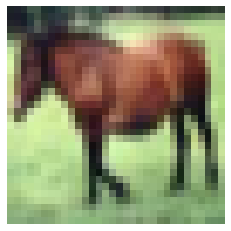

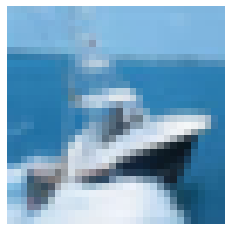

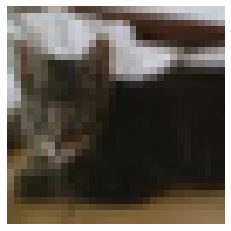

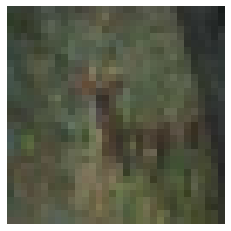

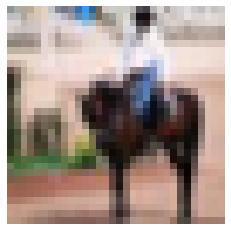

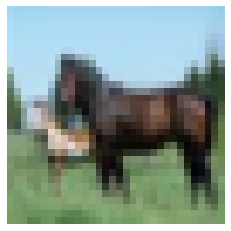

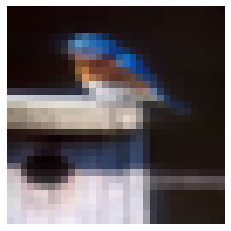

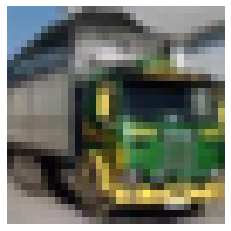

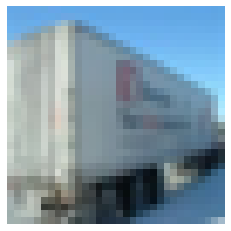

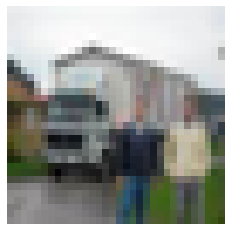

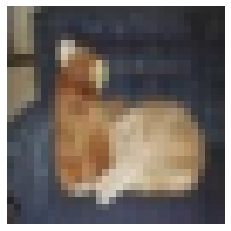

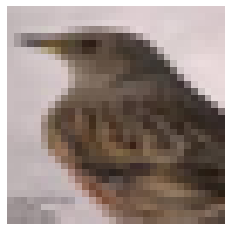

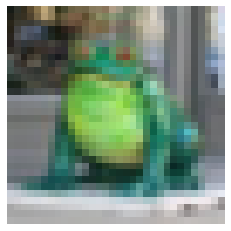

<Response [200]>
{'model_name': '', 'outputs': [{'data': None, 'name': 'fc10', 'shape': [20, 10], 'datatype': 'FP32'}, {'data': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'name': 'is_outlier', 'shape': [1, 20], 'datatype': 'INT64'}], 'rawOutputContents': ['CRx5MvEmrDCaAC80yx7sPdQqOzRRjs82t3tiP5Wy0DE1up8zppSiMUO3qTWauacxz0PQMM3dETKvihcwIqqfMP6uHjC/1Jo0wjAhOprXfz/ehGM/t/8pNrr5BznIr9c9k7XLN1+C1DYyJNU6s7Y9N1YmrjpFGjg7YuIMNuMSHjOy7q06mJe2NwiYfz+lcCA5JBzpNsDAXjcau4E4Q+22NIb9Ozcm/n8/ODFWNFMRljN5ZQ8zp+1hM/jzojRu2zsz7ewONcIhhTc1DSs6NEVaPD2vxjWSBHo/LRNROFk+GDpSuAk8D0WvNqBDdTn1XvM4AujfNRi1HjAgYH8/Y2KHOOVyGzseLt8zyFXRM8SGGzQEN2s1CKzUMojJrDHrxZYuI97SLBlGBzAu9x00HYI7NlCEbTHQ/38/elUjMN+yzy5CjS84a4hYM6pyrDPVIgI0/QPpMWy+WDJrEkwyUtTfMDz9fz8X8wwzPeS2PeUFFzQQv9w0JbNoP8nNbzWg9sw67mwROSeOGDdd4wI1XBjsNPHDKDnyab80WcGbPeiKZD/4Xpo6ggsuO1u73jzekIw25ghfNyor+TUUgLM18CTcM82jFDLQl5U2prl1N/09qTV8tzMyGPl/P1q+rjhhbdE0aR+JOGNfATOrDtwzG6j8Nfr7ATpdNBQ4OxqTNDTYfz/IaaI2/DRtNhenEDrcoqk0+L9/P/szpTmq3Vg1fanb

In [39]:
infer("cifar10-production.pipeline",20, "normal")

In [40]:
!seldon pipeline inspect cifar10-production.cifar10-drift.outputs.is_drift

---
seldon.default.model.cifar10-drift.outputs
{"name":"is_drift","datatype":"INT64","shape":["1"],"contents":{"int64Contents":["0"]}}


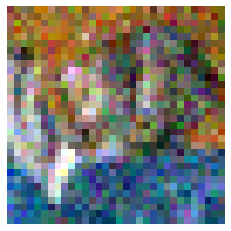

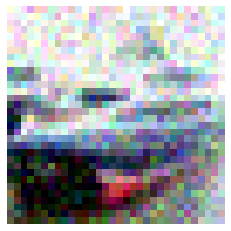

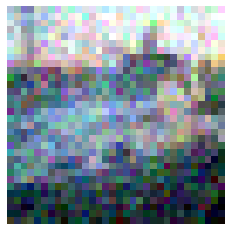

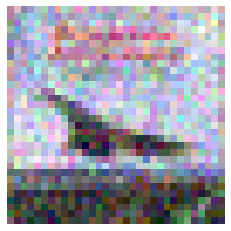

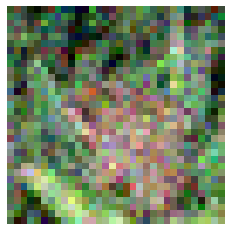

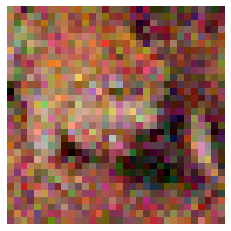

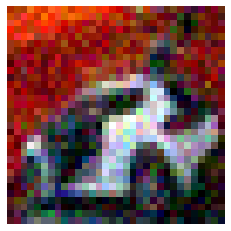

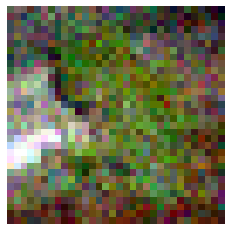

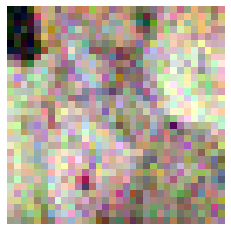

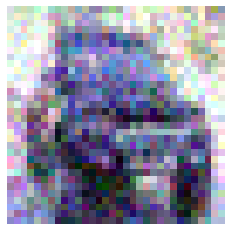

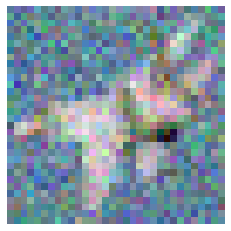

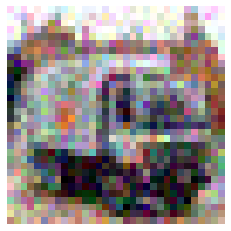

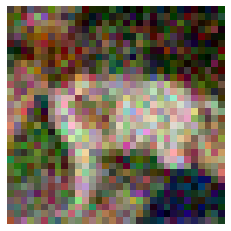

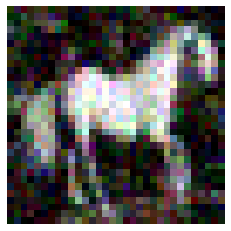

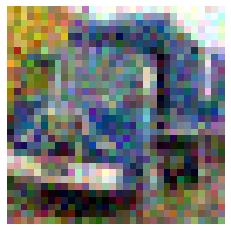

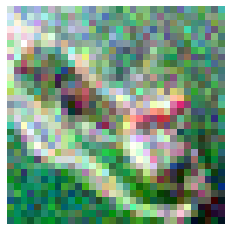

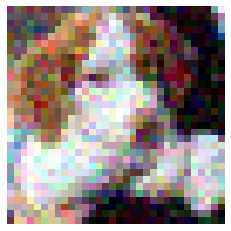

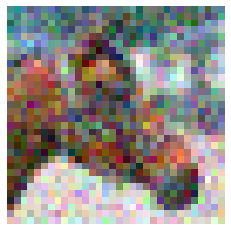

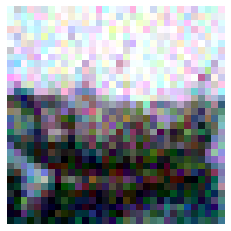

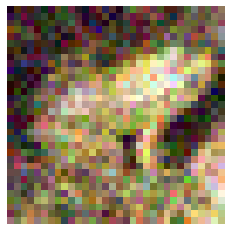

<Response [200]>
{'model_name': '', 'outputs': [{'data': None, 'name': 'fc10', 'shape': [20, 10], 'datatype': 'FP32'}, {'data': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], 'name': 'is_outlier', 'shape': [1, 20], 'datatype': 'INT64'}], 'rawOutputContents': ['1M3eMCFl3C/cUvA5KrBuP0Xg3jSP4Aw3uomJPdTueDAoMCEx6rwLL1u1rjrZcAs3o6htP2N/oTuhl+E7Bna8OQHG6TkQE0M3aDdsPel6jjZcLc82+rKNNiFiFTwwvR8/QKsUOLlYODm+MlU3OaxsNae7uz6jhyU1KYA0OBO6lTVRu3g/9GBsO5PPmTkLHu04hFAcOiNWgzddU8I8NA+CNfQAuTWWldAzJoHiPTiaYz97L0o40eYbOOw5fjnaVaA0r5sDNdkSgTKvbiA1Nj89NAlBjD6Eyzk/zY58OKIy7zh2MQA5XmvDNRQ5xzbrWwszxF3mMtLKqzLDAA855NtpP+kFgjS35as0EdmwPTeukzHv0KwxHQRCMdHlLzq9Myk4nyVaPzNBwT3kurA8dVkkOz/sGjuYRFE5eNnVPD8GKDhJm6E1lGNmM1QEZz6OIUQ/jwACOSgviTjYMgQ8PFLtNGmaFzW1J1Ez5h0qOCMUrTUKsw4+uldwPrzqgzwsjMY7qngaP6BNHDdvxqI518oDNwC6TjiV+481gd0hPqLJVj9lhoA6/agLOquEZzqryY42s27yOcapUjVeQAU4rgqzNbNP7T4k/jU8G5sAP8MnEzgdNLc8aoLcN2C6AzpLa4o44mihM05zZzMzXsw+x8cZP+MNWji1Hqo2MG6oOECFCzXUcJg1xYinMiSTFjO6AOUyGRrtOphZfz/laB04/GOW

In [41]:
infer("cifar10-production.pipeline",20, "drift")

In [42]:
!seldon pipeline inspect cifar10-production.cifar10-drift.outputs.is_drift

---
seldon.default.model.cifar10-drift.outputs
{"name":"is_drift","datatype":"INT64","shape":["1"],"contents":{"int64Contents":["1"]}}


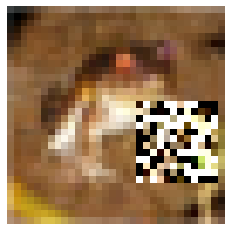

<Response [200]>
{'model_name': '', 'outputs': [{'data': None, 'name': 'fc10', 'shape': [1, 10], 'datatype': 'FP32'}, {'data': [1], 'name': 'is_outlier', 'shape': [1, 1], 'datatype': 'INT64'}], 'rawOutputContents': ['QiBWN0rRszUjms41yi+6PTzNBzYMkLA3/7ZoP45q0zUMqTg2ccNXNg==']}


In [43]:
infer("cifar10-production.pipeline",1, "outlier")

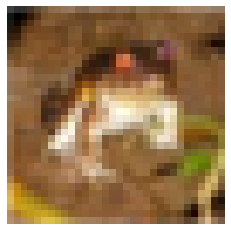

<Response [200]>
{'model_name': '', 'outputs': [{'data': None, 'name': 'fc10', 'shape': [1, 10], 'datatype': 'FP32'}, {'data': [0], 'name': 'is_outlier', 'shape': [1, 1], 'datatype': 'INT64'}], 'rawOutputContents': ['JRx5MgYnrDCDAC802B7sPd4qOzQ1js82tXtiP3my0DFHup8zpZSiMQ==']}


In [44]:
infer("cifar10-production.pipeline",1, "ok")

In [45]:
!seldon pipeline inspect cifar10-production.cifar10.outputs

---
seldon.default.model.cifar10.outputs
{"modelName":"cifar10_1","modelVersion":"1","outputs":[{"name":"fc10","datatype":"FP32","shape":["1","10"],"contents":{"fp32Contents":[1.4500107e-8,1.2525738e-9,1.6298331e-7,0.115293205,1.7431327e-7,0.000006185636,0.8847001,6.0738867e-9,7.437898e-8,4.7317195e-9]}}],"rawOutputContents":["JRx5MgYnrDCDAC802B7sPd4qOzQ1js82tXtiP3my0DFHup8zpZSiMQ=="]}


In [46]:
!seldon pipeline unload cifar10-production

{}


In [47]:
!seldon model unload cifar10
!seldon model unload cifar10-outlier
!seldon model unload cifar10-drift

{}
{}
{}
